# Reconhecimento de Padrões em Imagens com Redes Neurais Convolucionais

## Dogs-vs-Cats

## Objetivo

Este Notebook constrói, treina e aplica uma Rede Neural Convolucional para prever se uma imagem contém um cachorro ou um gato.


## Conjuto de dados (*Datasets*)

* #### Dados de treino: 8.000 imagens = 4.000 imagens de cães e 4.000 imagens de gatos
Utilizado para criar o modelo preditivo/classificador

* #### Dados de validação: 2.000 imagens = 1.000 imagens de cães e 1.000 imagens de gatos 
Utilizado para avaliar o modelo durante o treinamento

* #### Dados de teste: 1.000 imagens de cães e gatos 
Utilizado para validar o desempenho do modelo já treinado. A ideia é apresentar ao modelo dados que não foram utilizados no treinamento, a fim de garantir que ele seja capaz de fazer previsões (classificar os padrões corretamente).

*Fonte dos dados:* https://www.kaggle.com/c/dogs-vs-cats/data

## Habilitando GPU *(se quiser fazer um teste de speedup CPU X GPU [clique aqui](https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=oM_8ELnJq_wd))*

Uma vez que o treinamento da nossa rede neural convolucional pode ser muito demorado em função do tamanho do conjunto de dados, vamos habilitar a GPU no GCB.
1. Navegue até Editar → Configurações do Notebook
2. Selecione GPU no menu suspenso do Hardware Accelerator

Depois, confirme a conexão com a GPU executando o código abaixo:


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Carregamento (upload) dos dados:

Você deve ter criar a seguinte estrutura de diretórios:

* /dataset_teste

* /dataset_treino

* /dataset_validacao

In [3]:
from google.colab import files
uploaded = files.upload()

Saving datasets.zip to datasets.zip


## Descompactando os dados
Descompactando os dados e conferindo a estrutura de diretórios

In [4]:
!unzip -uq datasets.zip
!ls -l

total 244492
-rw-r--r-- 1 root root 250316738 Sep 11 00:56 datasets.zip
drwxr-xr-x 2 root root     24576 Sep 11 01:00 dataset_teste
drwxr-xr-x 4 root root      4096 Sep 11 01:00 dataset_treino
drwxr-xr-x 4 root root      4096 Sep 11 01:00 dataset_validacao
drwxr-xr-x 1 root root      4096 Aug 27 16:39 sample_data


Abaixo seguem visualizações de algumas imagens do conjunto de dados de treinamento (dataset_treino).

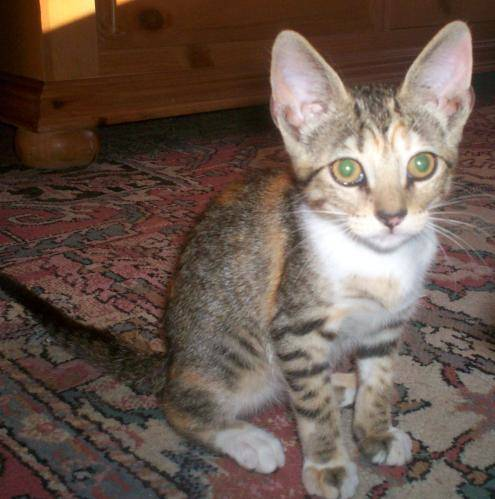

In [5]:
from IPython.display import Image
Image(filename = 'dataset_treino/cats/cat.7.jpg')

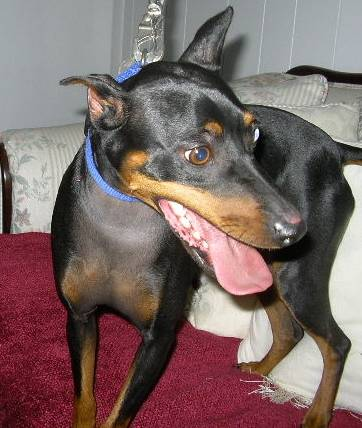

In [6]:
Image(filename='dataset_treino/dogs/dog.13.jpg')

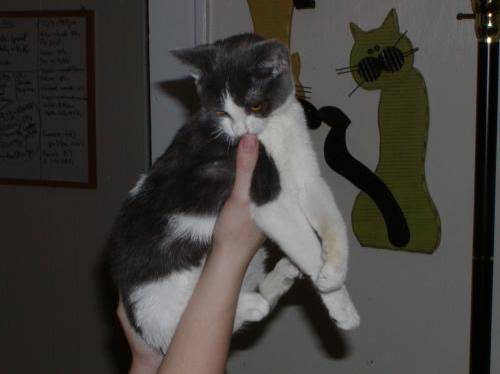

In [7]:
Image(filename='dataset_treino/cats/cat.3901.jpg')

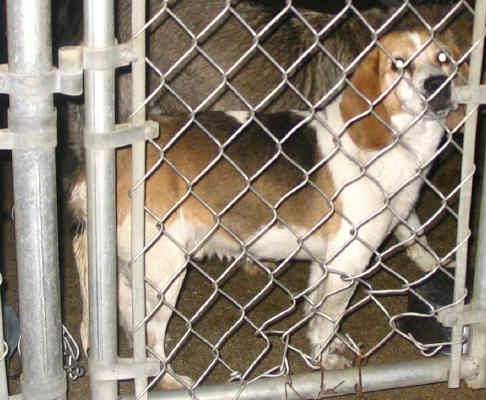

In [8]:
Image(filename='dataset_treino/dogs/dog.3998.jpg')

## Construção da Rede Neural Convolucional

Utilizamos o modelo sequencial oferecido pelo Keras para montarmos as camadas de nossa rede neural convolucional. Lembrando que o Keras utiliza o TensorFlow como backend. Na verdade, o Keras é apenas uma biblioteca para simplificar a complexidade do TensorFlow. 

Nessa versão, utilizamos a técnica de **transferência de aprendizagem** (*Transfer Learning*). 

A aprendizagem por transferência envolve o uso de todo ou partes de um modelo treinado em uma tarefa relacionada.

Keras fornece uma variedade de modelos pré-treinados que podem ser carregados e usados ​​total ou parcialmente por meio da API de aplicativos Keras.

Um modelo útil para aprendizagem por transferência é um dos modelos VGG, como o VGG-19 com 19 camadas que, na época em que foi desenvolvido, alcançou os melhores resultados no desafio de classificação de fotos ImageNet.

O modelo é composto de duas partes principais, a parte extratora de recursos do modelo que é composta de blocos VGG e a parte classificadora do modelo que é composta de camadas totalmente conectadas e a camada de saída.

Podemos usar a parte de extração de recursos do modelo e adicionar uma nova parte classificadora do modelo que é adaptada ao conjunto de dados de cães e gatos. Especificamente, podemos manter os pesos de todas as camadas convolucionais fixos durante o treinamento e apenas treinar novas camadas totalmente conectadas que aprenderão a interpretar os recursos extraídos do modelo e fazer uma classificação binária.

Isso pode ser obtido carregando o modelo VGG-16, removendo as camadas totalmente conectadas da extremidade de saída do modelo e, em seguida, adicionando as novas camadas totalmente conectadas para interpretar a saída do modelo e fazer uma previsão. A parte classificadora do modelo pode ser removida automaticamente definindo o argumento “include_top” como “False“, o que também requer que a forma da entrada também seja especificada para o modelo, neste caso (224, 224, 3). Isso significa que o modelo carregado termina na última camada de agrupamento máxima, após a qual podemos adicionar manualmente uma camada Flatten e as novas camadas classificadoras.


In [9]:
# Importação dos pacotes
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense

In [10]:
# definindo o classificador
# carrega o modelo VGG19
classifier = VGG19(include_top=False, input_shape=(224, 224, 3))
# marca as camadas como não treináveis (não terão os pesos ajustados)
for layer in classifier.layers:
	layer.trainable = False
# adiciona novas camadas de classificação (full-conection)
flat1 = Flatten()(classifier.layers[-1].output)
class1 = Dense(128, activation='relu')(flat1)
output = Dense(1, activation='sigmoid')(class1)
# define novo classificador
classifier = Model(inputs=classifier.inputs, outputs=output)

80142336/80134624 [==============================] - 1s 0us/step


### Resumo (sumário) da arquitetura da rede neural convolucional

Execute o comando abaixo para obter um resumo da arquitetura da rede neural convolucional construída e para ver também o número de parâmetros da mesma.


In [11]:
classifier.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

## Compilação da Rede Neural Convolucional

Utilizamos o otimizador Adam, que é uma versão melhorada do gradiente descendente; ele incorpora momento e taxa de aprendizado adaptativa.

A função de perda (ou função de erro) adotada, a qual deve ser minimizada, é a 'binary_crossentropy'.

E a métrica de desempenho 'accuracy' (proporção de casos corretamente previstos).

In [12]:
# Compilando a rede
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

## Treinamento da Rede Neural Convolucional
Uma vez construída (montada) a arquitetura da rede neural, o próximo passo é o **treinamento**.

### Pré-Processamento/*Augmentation*
No entanto, antes de realizar o treinamento é preciso realizar algum pré-processamento nos dados (imagens) e aplicar a técnica de '*augmentation*' nos dados de treinamento para diminuir a chance de ocorrência de overfitting. Para isso, utilizamos a função **ImageDataGenerator()** do Keras para ajustar a escala dos valores de entrada (de [0,255] para [0,1]) e aplicar transformações aleatórias nas imagens de treino (cortes, zoom e 'giros' nas imagens)

A técnica de '*augmentation*' possibilita que, no momento do treinamento, nosso modelo (classificador) nunca veja exatamente a mesma imagem duas vezes. Isso ajuda a evitar overfitting e ajuda o modelo a generalizar melhor.

O ajuste da escala dos valores de entrada (de [0,255] para [0,1]) deve ser aplicado também nas imagens de validação.

In [15]:
# Criando os objetos train_datagen e validation_datagen com as técnicas de pré-processamento e 'augmentation'
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)

Aplicação dos dois objetos criados anteriormente para pré-processar os dados de treino e de validação. 

In [16]:
# Aplicação dos dois objetos criados anteriormente para pré-processar os dados de treino e de validação.
training_set = train_datagen.flow_from_directory('dataset_treino',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

validation_set = validation_datagen.flow_from_directory('dataset_validacao',
                                                        target_size = (224, 224),
                                                        batch_size = 32,
                                                        class_mode = 'binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


### Treinamento

Vamos adotar 8000 passos em cada época de treinamento e 2000 passos de validação. Você pode obviamente alterar esses parâmetros, mas não deixe de observar os números de imagens em seus conjuntos de dados de treinamento e de validação.

Executar esse treinamento em uma máquina comum, com apenas uma CPU, pode ser muito demorado! Alternativamente, você pode utilizar a GPU do Colab.

In [17]:
# Execução do treinamento
history = classifier.fit_generator(training_set,
                         steps_per_epoch = 8000//32,
                         epochs = 5,
                         validation_data = validation_set,
                         validation_steps = 2000//32)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
250/250 [==============================] - 113s 452ms/step - loss: 0.3688 - accuracy: 0.8447 - val_loss: 0.2309 - val_accuracy: 0.9012
Epoch 2/5
250/250 [==============================] - 114s 454ms/step - loss: 0.2288 - accuracy: 0.9062 - val_loss: 0.2001 - val_accuracy: 0.9183
Epoch 3/5
250/250 [==============================] - 114s 457ms/step - loss: 0.2088 - accuracy: 0.9130 - val_loss: 0.2107 - val_accuracy: 0.9168
Epoch 4/5
250/250 [==============================] - 115s 462ms/step - loss: 0.1956 - accuracy: 0.9149 - val_loss: 0.2114 - val_accuracy: 0.9108
Epoch 5/5
250/250 [==============================] - 117s 468ms/step - loss: 0.1651 - accuracy: 0.9330 - val_loss: 0.1937 - val_accuracy: 0.9274


## Análise da função *loss* (erro/perda)
Vamos observar o comportamento da função *loss* para os dados de treino e de validação.

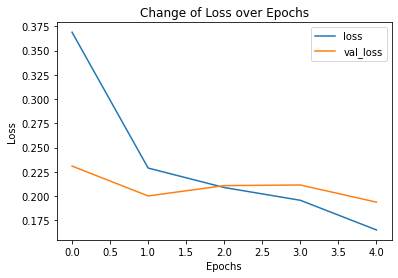

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], '')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.title('Change of Loss over Epochs')
plt.legend(['loss', 'val_loss'])
plt.show()

## Análise da métrica de desempenho (acurácia)
Vamos observar o desempenho (acurácia) da rede para os dados de treino e de validação.

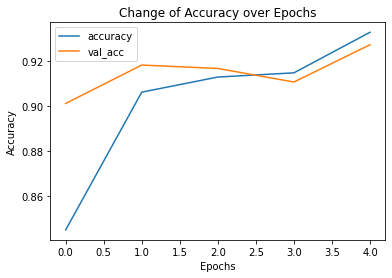

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], '')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.title('Change of Accuracy over Epochs')
plt.legend(['accuracy', 'val_acc'])
plt.show()

## Teste da rede neural treinada

Após o treinamento da rede, vamos realizar alguns testes com as imagens do conjunto de dados de teste (imagens que não foram fornecidas para a rede neural durante o treinamento).

Cada imagem a ser testada deve ser redimensionada para o formato utilizado no treinamento da rede neural (64x64) e convertida para um array. 

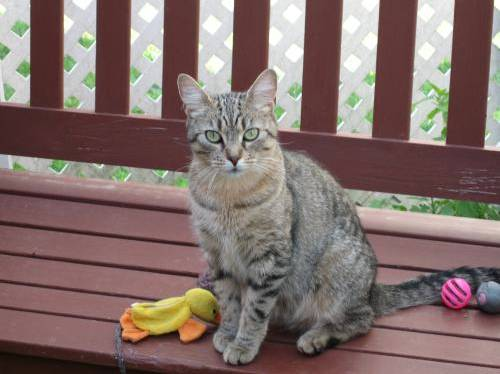

Gato

Deseja testar outra imagem? (S|N)s


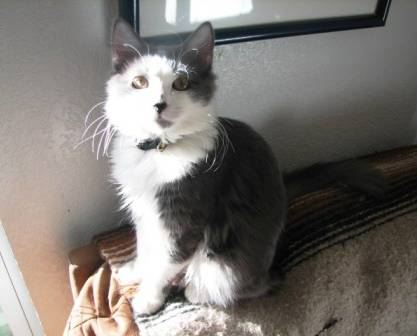

Gato

Deseja testar outra imagem? (S|N)s


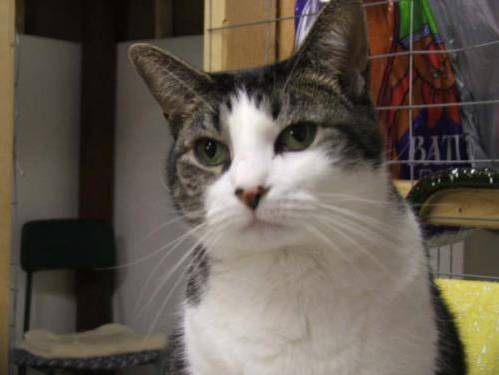

Gato

Deseja testar outra imagem? (S|N)s


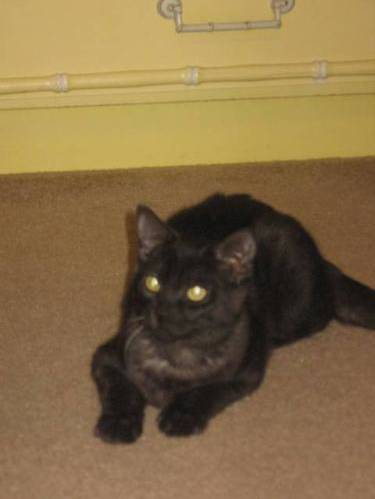

Gato

Deseja testar outra imagem? (S|N)s


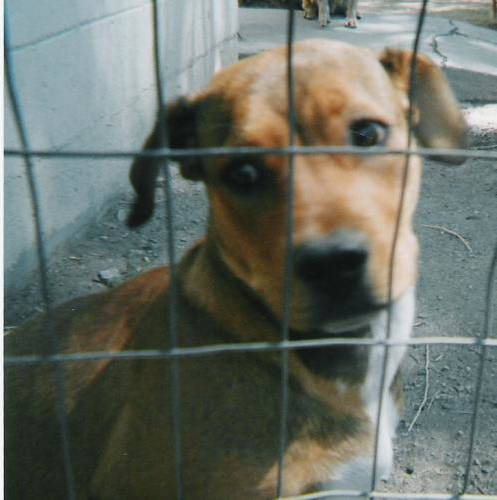

Cachorro

Deseja testar outra imagem? (S|N)s


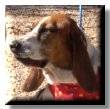

Cachorro

Deseja testar outra imagem? (S|N)s


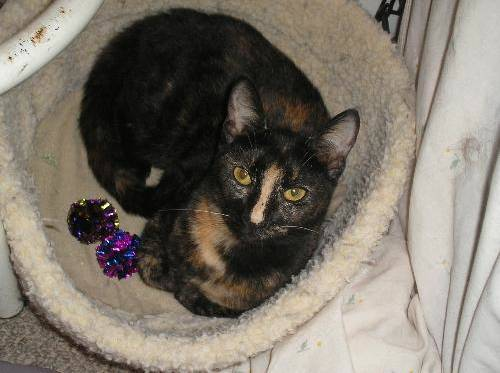

Gato

Deseja testar outra imagem? (S|N)s


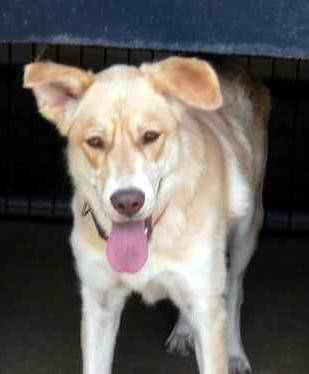

Cachorro

Deseja testar outra imagem? (S|N)s


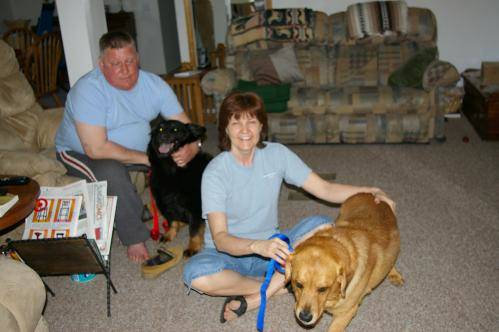

Cachorro

Deseja testar outra imagem? (S|N)s


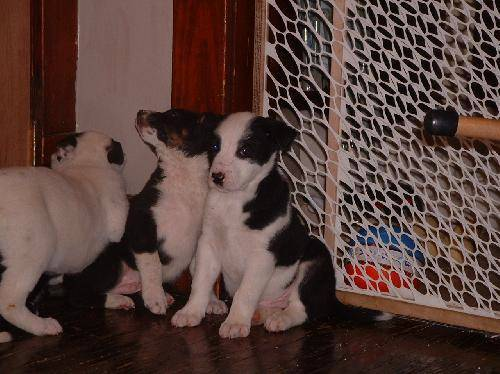

Cachorro

Deseja testar outra imagem? (S|N)s


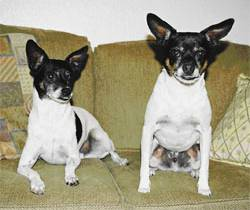

Cachorro

Deseja testar outra imagem? (S|N)s


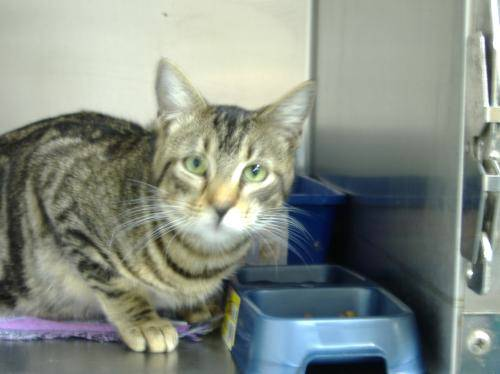

Gato

Deseja testar outra imagem? (S|N)s


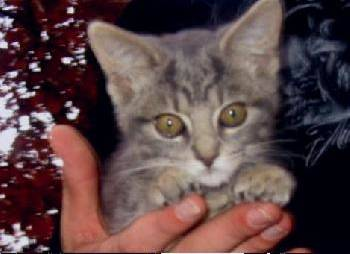

Gato

Deseja testar outra imagem? (S|N)s


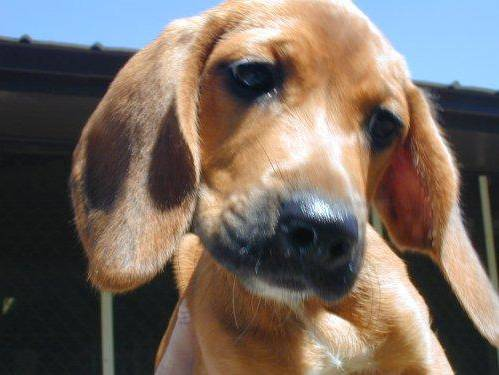

Cachorro

Deseja testar outra imagem? (S|N)s


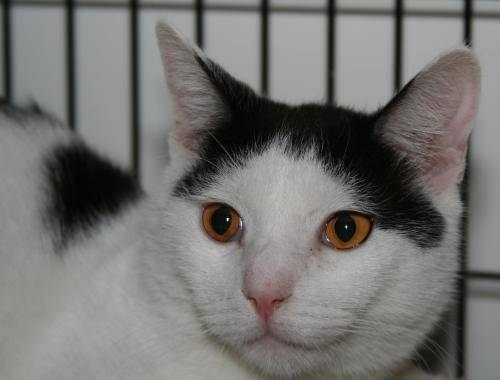

Gato

Deseja testar outra imagem? (S|N)s


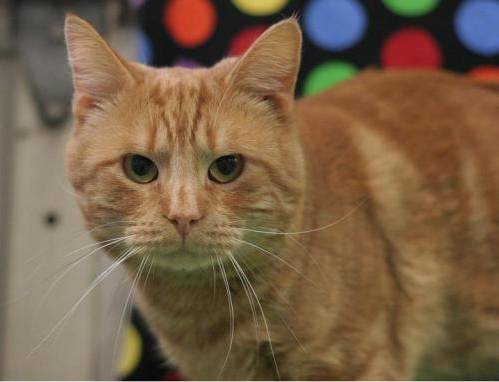

Gato

Deseja testar outra imagem? (S|N)s


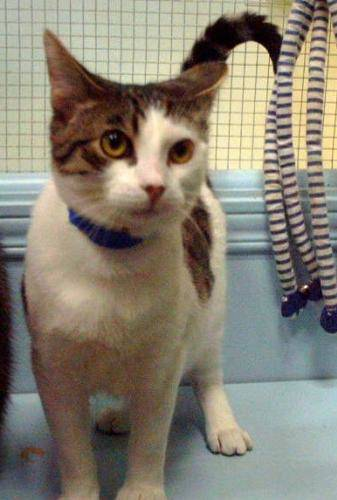

Gato

Deseja testar outra imagem? (S|N)s


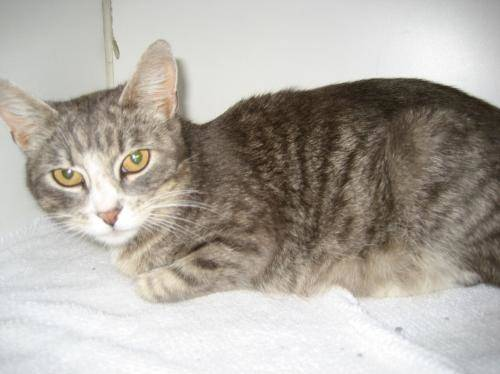

Gato

Deseja testar outra imagem? (S|N)s


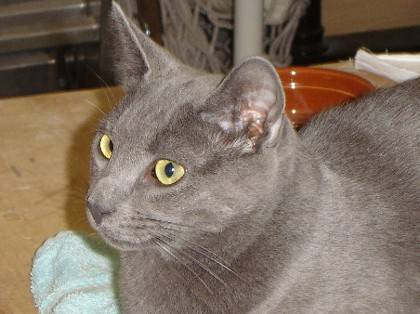

Gato

Deseja testar outra imagem? (S|N)s


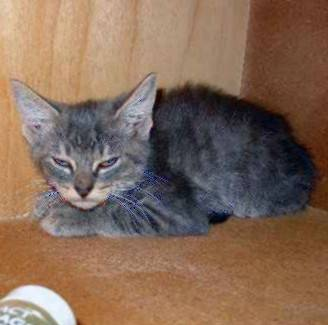

Gato

Deseja testar outra imagem? (S|N)s


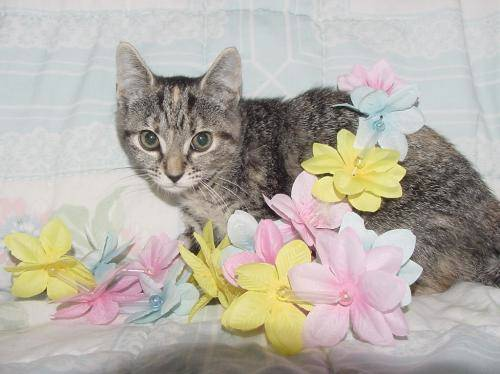

Gato

Deseja testar outra imagem? (S|N)s


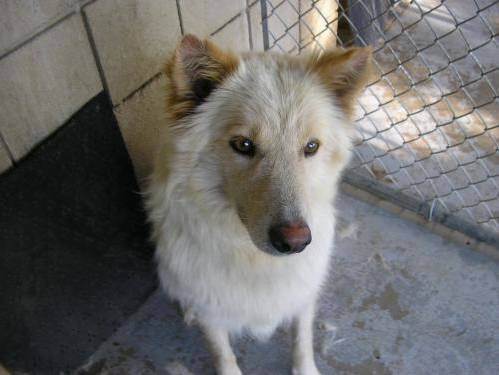

Cachorro

Deseja testar outra imagem? (S|N)s


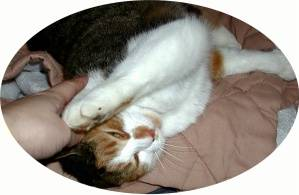

Cachorro

Deseja testar outra imagem? (S|N)s


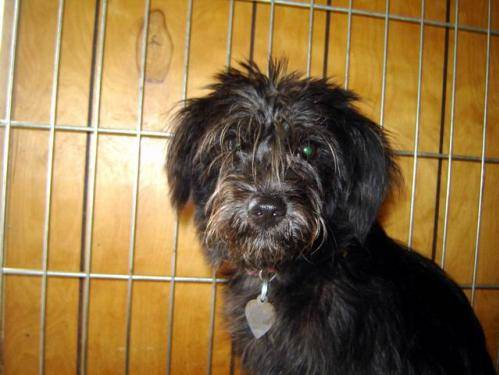

Cachorro

Deseja testar outra imagem? (S|N)s


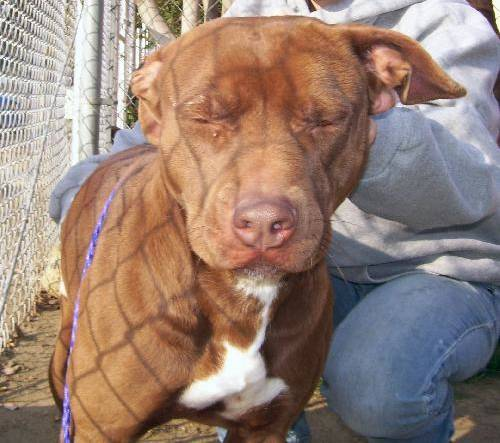

Cachorro

Deseja testar outra imagem? (S|N)s


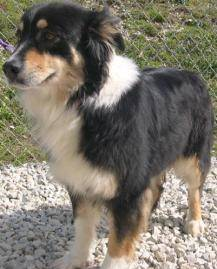

Cachorro

Deseja testar outra imagem? (S|N)s


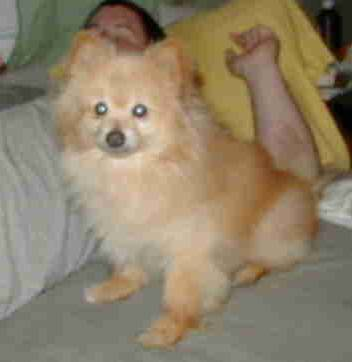

Cachorro

Deseja testar outra imagem? (S|N)s


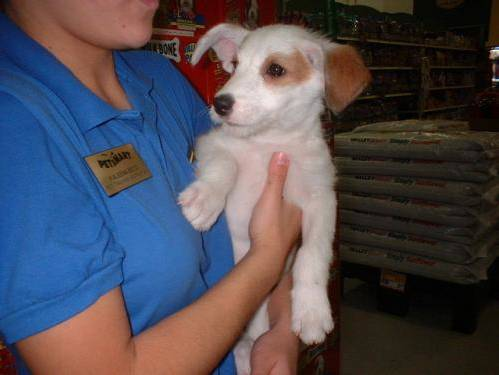

Cachorro

Deseja testar outra imagem? (S|N)s


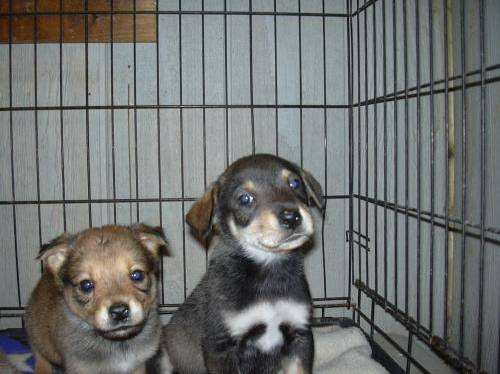

Cachorro

Deseja testar outra imagem? (S|N)s


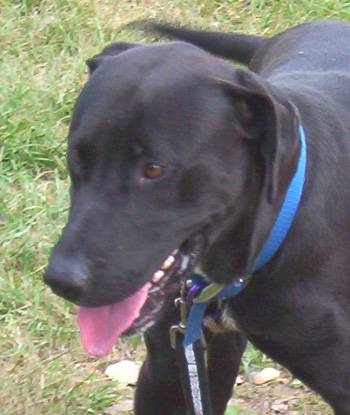

Cachorro

Deseja testar outra imagem? (S|N)n


In [20]:
import numpy as np
from keras.preprocessing import image
from IPython.display import display, Image

Repetir_teste = 'S'
num_img = 2149

while Repetir_teste.upper() != 'N':
    num_img = num_img + 1
    file_name = 'dataset_teste/'+str(num_img)+'.jpg'
    imagem_teste = image.load_img(file_name, target_size = (224, 224))
    imagem_teste= image.img_to_array(imagem_teste)
    imagem_teste = np.expand_dims(imagem_teste, axis = 0)
    predicao = classifier.predict(imagem_teste) # resposta do classificador
    training_set.class_indices
    #print(training_set.class_indices)
    
    display(Image(file_name)) # exibe a imagem teste
    
    if predicao[0][0] == 1:  
        print('Cachorro')
    else:
        print('Gato')  
         
    Repetir_teste = input("\nDeseja testar outra imagem? (S|N)")

## Exercícios (sugestões) para melhorar a precisão do classificador

1. Incluir mais camadas convolucionais
2. Aumentar o número de épocas de treinamento
3. Aumentar o conjunto de dados de treinamento e validação (https://www.kaggle.com/c/dogs-vs-cats/data)
4. Aumentar o tamanho do lote (de 32 para 64)
5. Redimensionar as imagens (de 64x64 para 256x256)
6. Aplicar outras transformações nas imagens - técnica Dataset Augmentation: 
   * https://keras.io/api/preprocessing/image/
7. Testar outras métricas e/ou algoritmos de otimização: 
   * https://keras.io/api/metrics/accuracy_metrics/
   * https://keras.io/api/optimizers/
   * https://keras.io/api/losses/

**Leaderboard:**https://www.kaggle.com/c/dogs-vs-cats/leaderboard


## Fim